# Panorama magic  Lab3

https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/

In [3]:
# import the necessary packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imutils
import cv2
 
class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = imutils.is_cv3()
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,
        showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
 
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
 
        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None
        
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
 
        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
 
            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)
 
        # return the stitched image
        return result
    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
        # check to see if we are using OpenCV 3.X
        if self.isv3:
            # detect and extract features from the image
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)
 
        # otherwise, we are using OpenCV 2.4.X
        else:
            # detect keypoints in the image
            detector = cv2.FeatureDetector_create("SIFT")
            kps = detector.detect(gray)
 
            # extract features from the image
            extractor = cv2.DescriptorExtractor_create("SIFT")
            (kps, features) = extractor.compute(gray, kps)
 
        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])
 
        # return a tuple of keypoints and features
        return (kps, features)
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
 
        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
 
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
 
            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)
 
        # otherwise, no homograpy could be computed
        return None
    
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
 
        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
 
        # return the visualization
        return vis

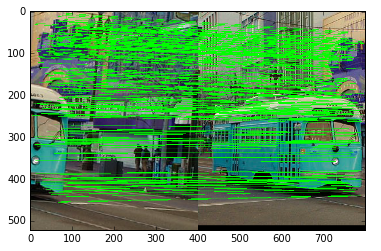

In [14]:
# import the necessary packages
import argparse
import imutils
import cv2
 
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--first", required=True,
# 	help="path to the first image")
# ap.add_argument("-s", "--second", required=True,
# 	help="path to the second image")
# args = vars(ap.parse_args())

# load the two images and resize them to have a width of 400 pixels
# (for faster processing)

imageA = cv2.imread("left.jpg")
imageB = cv2.imread("right.jpg")
imageA = imutils.resize(imageA, width=400)
imageB = imutils.resize(imageB, width=400)

# imageA = cv2.imread(args["first"])
# imageB = cv2.imread(args["second"])

 
# # stitch the images together to create a panorama
stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)
 
# # show the images
# cv2.imshow("Image A", imageA)
# cv2.imshow("Image B", imageB)


plt.imshow(vis)

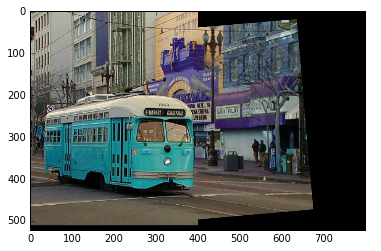

In [13]:
plt.imshow(result)